<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML321ENSkillsNetwork817-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Course Rating Prediction using Neural Networks**


In [2]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
# Set random seed for reproducibility
seed_value = 42
tf.random.set_seed(seed_value)
np.random.seed(seed_value)

In [4]:
# also set a random state
rs = 123

### Load and processing rating dataset


In [5]:
rating_url = "data/ratings.csv"
rating_df = pd.read_csv(rating_url)
rating_df.head()

,user,item,rating
0,1889878,CC0101EN,5
1,1342067,CL0101EN,3
2,1990814,ML0120ENv3,5
3,380098,BD0211EN,5
4,779563,DS0101EN,3


In [6]:
num_users = len(rating_df['user'].unique())
num_items = len(rating_df['item'].unique())
print(f"There are total `{num_users}` of users and `{num_items}` items")

There are total `33901` of users and `126` items


The goal is to create a neural network structure that can take the user and item one-hot vectors as inputs and outputs a rating estimation or the probability of interaction (such as the probability of completing a course). 

While training and updating the weights in the neural network, its hidden layers should be able to capture the pattern or features for each user and item. Based on this idea, we can design a simple neural network architecture like the following:


The network inputs are two one-hot encoding vectors, the blue one is for the user and the green one is for the item. Then on top of them, we added two embedding layers. Here embedding means embedding the one-hot encoding vector into a latent feature space. The embedding layer is a fully-connected layer that outputs the embedding feature vectors. For example, the user embedding layer takes `33901 x 1` one-hot vector as input and outputs a `16 x 1` embedding vector.


The embedding layer outputs two embedding vectors, which are similar to Non-negative matrix factorization. Then we could simply dot the product the user and item embedding vector to output a rating estimation.


#### Implementing the recommender neural network using tensorflow 


In [7]:
class RecommenderNet(keras.Model):
    
    def __init__(self, num_users, num_items, embedding_size=16, **kwargs):
        """
           Constructor
           :param int num_users: number of users
           :param int num_items: number of items
           :param int embedding_size: the size of embedding vector
        """
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        
        # Define a user_embedding vector
        # Input dimension is the num_users
        # Output dimension is the embedding size
        self.user_embedding_layer = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            name='user_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # Define a user bias layer
        self.user_bias = layers.Embedding(
            input_dim=num_users,
            output_dim=1,
            name="user_bias")
        
        # Define an item_embedding vector
        # Input dimension is the num_items
        # Output dimension is the embedding size
        self.item_embedding_layer = layers.Embedding(
            input_dim=num_items,
            output_dim=embedding_size,
            name='item_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # Define an item bias layer
        self.item_bias = layers.Embedding(
            input_dim=num_items,
            output_dim=1,
            name="item_bias")
        
    def call(self, inputs):
        """
           method to be called during model fitting
           
           :param inputs: user and item one-hot vectors
        """
        # Compute the user embedding vector
        user_vector = self.user_embedding_layer(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding_layer(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])
        dot_user_item = tf.tensordot(user_vector, item_vector, 2)
        # Add all the components (including bias)
        x = dot_user_item + user_bias + item_bias
        # Sigmoid output layer to output the probability

        return tf.nn.relu(x)

    

### Training and evaluate the RecommenderNet()


In [8]:
def process_dataset(raw_data):
    
    encoded_data = raw_data.copy()
    
    # Mapping user ids to indices
    user_list = encoded_data["user"].unique().tolist()
    user_id2idx_dict = {x: i for i, x in enumerate(user_list)}
    user_idx2id_dict = {i: x for i, x in enumerate(user_list)}
    
    # Mapping course ids to indices
    course_list = encoded_data["item"].unique().tolist()
    course_id2idx_dict = {x: i for i, x in enumerate(course_list)}
    course_idx2id_dict = {i: x for i, x in enumerate(course_list)}

    # Convert original user ids to idx
    encoded_data["user"] = encoded_data["user"].map(user_id2idx_dict)
    # Convert original course ids to idx
    encoded_data["item"] = encoded_data["item"].map(course_id2idx_dict)
    # Convert rating to int
    encoded_data["rating"] = encoded_data["rating"].values.astype("int")

    return encoded_data, user_idx2id_dict, course_idx2id_dict

In [9]:
encoded_data, user_idx2id_dict, course_idx2id_dict = process_dataset(rating_df[rating_df['user'] == 2])

In [13]:
encoded_data, user_idx2id_dict, course_idx2id_dict = process_dataset(rating_df)

Then we can split the encoded dataset into training and testing datasets.


In [24]:
def generate_train_test_datasets(dataset, scale=True):

    min_rating = min(dataset["rating"])
    max_rating = max(dataset["rating"])

    dataset = dataset.sample(frac=1, random_state=42)
    x = dataset[["user", "item"]].values
    if scale:
        y = dataset["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
    else:
        y = dataset["rating"].values

    # Assuming training on 80% of the data and validating on 10%, and testing 10%
    train_indices = int(0.8 * dataset.shape[0])
    test_indices = int(0.9 * dataset.shape[0])

    x_train, x_val, x_test, y_train, y_val, y_test = (
        x[:train_indices],
        x[train_indices:test_indices],
        x[test_indices:],
        y[:train_indices],
        y[train_indices:test_indices],
        y[test_indices:],
    )
    return x_train, x_val, x_test, y_train, y_val, y_test

In [25]:
x_train, x_val, x_test, y_train, y_val, y_test = generate_train_test_datasets(encoded_data)

In [26]:
user_indices = x_train[:, 0]
user_indices

array([ 8376,  7659, 10717, ...,  3409, 28761,  4973], dtype=int64)

In [27]:
item_indices = x_train[:, 1]
item_indices

array([12, 29,  3, ..., 18, 19, 17], dtype=int64)

and training output labels are a list of 0s and 1s indicating if the user has completed a course or not.


In [28]:
y_train

array([0., 0., 0., ..., 0., 1., 0.])

Then we can choose a small embedding vector size to be 16 and create a `RecommenderNet()` model to be trained


In [29]:
embedding_size = 16
model = RecommenderNet(num_users, num_items, embedding_size)

Epoch 1/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - loss: 0.2292 - root_mean_squared_error: 0.4762 - val_loss: 0.1788 - val_root_mean_squared_error: 0.4221
Epoch 2/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 0.1750 - root_mean_squared_error: 0.4175 - val_loss: 0.1756 - val_root_mean_squared_error: 0.4179
Epoch 3/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 0.1616 - root_mean_squared_error: 0.4008 - val_loss: 0.1782 - val_root_mean_squared_error: 0.4208
Epoch 4/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 0.1537 - root_mean_squared_error: 0.3905 - val_loss: 0.1821 - val_root_mean_squared_error: 0.4251
Epoch 5/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 0.1511 - root_mean_squared_error: 0.3868 - val_loss: 0.1867 - val_root_mean_squared_error: 0.4301
Epoch 6/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - loss: 0.1501 - root_mean_squared_error: 0.3852 - val_loss: 0.1897 - val_root_mean_squared_error: 0.4334
Epoch 7/10
2917/2917 ━━━━━━━━━━━━━

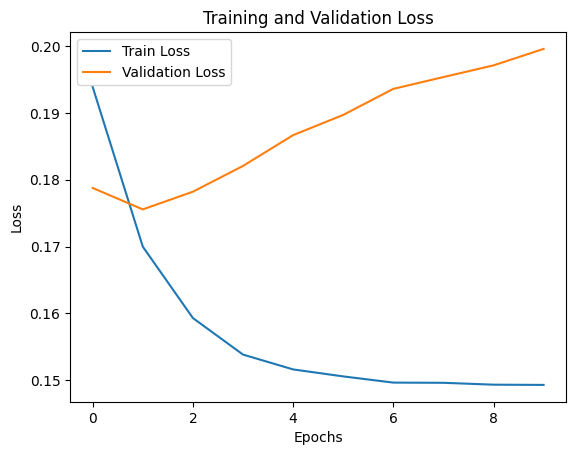

In [30]:
 model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(),
    metrics=[tf.keras.metrics.RootMeanSquaredError()],
)

history = model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), batch_size=64, epochs=10, verbose = 1)
# Plotting the train and validation loss
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [31]:
 model.evaluate(x_test, y_test)

730/730 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1972 - root_mean_squared_error: 0.4412


[0.1974073350429535, 0.4415201246738434]

### Extract the user and item embedding vectors as latent feature vectors



If we print the trained model then we can see its layers and their parameters/weights.


In [32]:
model.summary()

Model: "recommender_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ user_embedding_layer (Embedding)     │ ?                           │         542,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ user_bias (Embedding)                │ ?                           │          33,901 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ item_embedding_layer (Embedding)     │ ?                           │           2,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ item_bias (Embedding)                │ ?                           │             126 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,735,379 (6.62 MB)

 Trainable params: 578,459 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,156,920 (4.41 MB)

In [33]:
# User features
user_latent_features = model.get_layer('user_embedding_layer').get_weights()[0]
print(f"User features shape: {user_latent_features.shape}")

User features shape: (33901, 16)


In [34]:
user_latent_features[0]

array([-0.01239258,  0.09180754,  0.0111135 , -0.05705348, -0.07520021,
        0.06175241,  0.02233238,  0.01813447, -0.1037591 ,  0.19498152,
        0.09764618, -0.05608968, -0.05512728,  0.04442069,  0.01534516,
        0.09544216], dtype=float32)

In [35]:
item_latent_features = model.get_layer('item_embedding_layer').get_weights()[0]
print(f"Item features shape: {item_latent_features.shape}")

Item features shape: (126, 16)


In [36]:
item_latent_features[0]

array([-0.01823152, -0.00253805, -0.0004487 , -0.0047867 , -0.01316659,
       -0.02256106,  0.00670972,  0.00944556,  0.01789977,  0.03980039,
       -0.021531  ,  0.00805809, -0.00438481, -0.02096088, -0.02191758,
       -0.00907735], dtype=float32)

Now, each user of the total 33901 users has been transformed into a 16 x 1 latent feature vector and each item of the total 126 has been transformed into a 16 x 1 latent feature vector.


In [61]:
model.save('RecommenderNet.h5')